## 위치기록 데이터 시각화

In [1]:
import requests
import json
import folium
from folium.plugins import HeatMap
import pandas as pd
import datetime
from typing import Tuple, List
import numpy as np

class GeoDataHandler:
    def __init__(self):
        with open("./etc/tmap_key.txt") as lf:
            self.__TMAP_KEY = lf.read()

        self.__GEOCODING_URL = "https://apis.openapi.sk.com/tmap/pois?version=1&appKey=" + self.__TMAP_KEY + "&"
        self.__REVERSE_URL = "https://apis.openapi.sk.com/tmap/geo/reversegeocoding?version=1&appKey=" + self.__TMAP_KEY + "&"
        self.__WALKING_URL = "https://apis.openapi.sk.com/tmap/routes/pedestrian?version=1"
        self.__DRIVING_URL = "https://apis.openapi.sk.com/tmap/routes?version=1"
        
    # Singleton 패턴
    def __new__(cls):
        if not hasattr(cls, 'instance'):
            cls.instance = super(GeoDataHandler, cls).__new__(cls)
        return cls.instance
    
    # 주소지를 입력하면, 위경도(str)를 tuple로 반환한다.
    def getLatLngByAddress(self, address:str) -> Tuple[str, str]:
        url = self.__GEOCODING_URL + "searchKeyword=" + address
        resp = requests.get(url)
        dic = json.loads(resp.text)
        lat = dic['searchPoiInfo']['pois']['poi'][0]['noorLat']
        lng = dic['searchPoiInfo']['pois']['poi'][0]['noorLon']
        return lat, lng

    # 위경도를 list로 입력하면, 주소지를 str로 반환한다.
    def getAddressByLatLng(self, lat_lng):
        url = self.__REVERSE_URL + "lat=" + str(lat_lng[0]) + "&lon=" + str(lat_lng[1])
        resp = requests.get(url)
        dic = json.loads(resp.text)
        address = dic['addressInfo']['fullAddress']
        return address

    # Features Dictionary 에서 Coordinate 값을 추출한다.
    def __getCoordinateFromFeature(self, features):
        steps = []
        for feature in features:
            if feature['geometry']['type'] == 'LineString':
                for coordinate in feature['geometry']['coordinates']:
                    steps.append(coordinate[::-1])
            if feature['properties']['description'] == '도착':
                break
        return steps
    
    # direction 정보를 요청하여 예상 이동경로의 위경도값을 list로 반환한다.
    def __requestDirections(self, url, data):
        headers = {'appKey' : self.__TMAP_KEY}
        resp = requests.post(url, headers=headers, data=data)
        dic = json.loads(resp.text)
        return self.__getCoordinateFromFeature(dic['features'])
    
    def __passToString(self, pass_lat_lng):
        stringList = []
        for lat_lng in pass_lat_lng:
            stringList.append(",".join(list(map(str,lat_lng[::-1]))))
        return "_".join(stringList)
        
    # 시작주소와 도착주소, 경유주소를 입력하면, 도보로 이동하는 위치들을 list로 반환한다.
    def getWalkingDirectionByAddress(self, start_address, end_address, pass_address=[]):
        data = {}
        data['startName'] = start_address
        data['startY'], data['startX'] = self.getLatLngByAddress(start_address)
        data['endName'] = end_address
        data['endY'], data['endX'] = self.getLatLngByAddress(end_address)
        data['passList'] = self.__passToString(list(map(lambda x : list(self.getLatLngByAddress(x)), pass_address)))
        steps = self.__requestDirections(self.__WALKING_URL, data)
        return steps

    # 시작점과 도착점의 위경도를 list로 입력하면, 도보로 이동하는 위치들을 list로 반환한다.
    def getWalkingDirectionByLatLng(self, start_lat_lng : List[float], end_lat_lng: List[float], pass_lat_lng=[]):
        data = {}
        [data['startY'], data['startX']] = start_lat_lng
        [data['endY'], data['endX']] = end_lat_lng
        data['startName'] = self.getAddressByLatLng(start_lat_lng)
        data['endName'] = self.getAddressByLatLng(end_lat_lng)
        data['passList'] = self.__passToString(pass_lat_lng)
        steps = self.__requestDirections(self.__WALKING_URL, data)
        return steps
    
    # 시작주소와 도착주소를 입력하면, 차로 이동하는 위치들을 list로 반환한다.
    def getDrivingDirectionByAddress(self, start_address, end_address, pass_address=[]):
        data = {}
        data['startY'], data['startX'] = self.getLatLngByAddress(start_address)
        data['endY'], data['endX'] = self.getLatLngByAddress(end_address)
        data['passList'] = self.__passToString(list(map(lambda x : list(self.getLatLngByAddress(x)), pass_address)))
        steps = self.__requestDirections(self.__DRIVING_URL, data)
        return steps
    
    # 시작점과 도착점의 위경도를 list로 입력하면, 차로 이동하는 위치들을 list로 반환한다.
    def getDrivingDirectionByLatLng(self, start_lat_lng : List[float], end_lat_lng: List[float], pass_lat_lng=[]):
        data = {}
        [data['startY'], data['startX']] = start_lat_lng
        [data['endY'], data['endX']] = end_lat_lng
        data['passList'] = self.__passToString(pass_lat_lng)
        steps = self.__requestDirections(self.__DRIVING_URL, data)
        return steps


class MapHandler:
    def __init__(self):
        self.m = folium.Map(location=[36, 128], zoom_start = 7)

    # Singleton 패턴
    def __new__(cls):
        if not hasattr(cls, 'instance'):
            cls.instance = super(MapHandler, cls).__new__(cls)
        return cls.instance        
        
    def initMap(self):
        self.m = folium.Map(location=[36, 128], zoom_start = 7)
        return self.m
        
    def visualizePolyLine(self, steps):
        for i in range(len(steps) - 1):
            folium.PolyLine([steps[i], steps[i+1]], color="#00498c",weight=4,opacity=0.7).add_to(self.m)
        return self.m
  
    def visualizeMarker(self, markers, center={}, count=10):
        if center:
            folium.Marker([center['latitude'], center['longitude']], popup=center['address']).add_to(self.m)
        for index, row in markers.iterrows():
            folium.CircleMarker(row[['latitude', 'longitude']], radius = 8, color='#B70205', fill_color='#B70205', popup=str(row['datetime'])).add_to(self.m)
        return self.m
    
    def visualizeHeatmap(self, location):
        heatmap_data = np.concatenate((location.values, np.ones((len(location.values), 1)) * 0.2), axis=1)
        HeatMap(heatmap_data).add_to(self.m)
        return self.m


class LocationDataHandler:
    def __init__(self, filepath='', fp=None):
        self.__calcDistance = np.vectorize(self.__calcDistance)
        if not fp:
            if not filepath:
                LOCATION_FILEPATH = './data/LocationHistory.json'
                filepath = LOCATION_FILEPATH
            fp = open(filepath, 'r')
        raw = json.loads(fp.read())
        self.location_data = self.preprocess(raw)
    
    def preprocess(self, raw):
        location_data = pd.DataFrame(raw['locations'])
        location_data = location_data[location_data.accuracy < 1000]
        location_data['latitudeE7'] = location_data['latitudeE7']/float(1e7)
        location_data['longitudeE7'] = location_data['longitudeE7']/float(1e7)
        location_data['timestampMs'] = location_data['timestampMs'].map(lambda x: ((float(x)/1000)))
        location_data['datetime'] = location_data.timestampMs.map(lambda x: datetime.datetime.fromtimestamp(x, datetime.timezone(datetime.timedelta(hours=9))))
        location_data.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude'}, inplace=True)
        location_data = location_data.drop(['accuracy', 'activity', 'altitude', 'heading', 'timestampMs', 'velocity', 'verticalAccuracy'], axis=1)
        location_data = location_data.sort_values(by=['datetime'])
        location_data.reset_index(drop=True, inplace=True)
        return location_data

    def __calcDistance(self, lat1, lon1, lat2, lon2):
        R = 6373.0
        lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a)) 
        distance = R * c
        return distance
    
    def getNearestLocation(self, address, count=10) -> Tuple[dict, pd.DataFrame]:
        gh = GeoDataHandler()
        place_lat_lng = list(map(float,gh.getLatLngByAddress(address)))
        address = gh.getAddressByLatLng(place_lat_lng)
        center = {'latitude':float(place_lat_lng[0]), 'longitude':float(place_lat_lng[1]), 'address':address}
        self.location_data['distance'] = self.__calcDistance(self.location_data['latitude'], self.location_data['longitude'], place_lat_lng[0], place_lat_lng[1])
        nearest_location = self.location_data.iloc[self.location_data['distance'].nsmallest(count).index]
        self.location_data = self.location_data.drop('distance', axis=1)
        return center, nearest_location
    
    def getTimeLocation(self, from_time, to_time):
        return self.location_data[(self.location_data.datetime >= from_time) & (self.location_data.datetime <= to_time)]
    
    def getPassLatLng(self, time_location, passCount):
        pass_lat_lng = []
        passCount = min(5, max(0, passCount))
        for i in range(1, passCount+1):
            idx = int(len(time_location) * i / (passCount+1))
            pass_lat_lng.append(time_location.iloc[idx][['latitude', 'longitude']].tolist())
        return pass_lat_lng
        

# 이 클래스를 완성시켜야 함
class MapService:
    def __init__(self, lh):
        self.lh = lh
        self.mh = MapHandler()
        self.gh = GeoDataHandler()
        
    def visualizeNearestLocation(self, address):
        self.mh.initMap()
        center, markers = self.lh.getNearestLocation(address)
        return self.mh.visualizeMarker(markers, center=center)
    
    def visualizeTimeLocation(self, from_time, to_time):
        self.mh.initMap()
        time_location = self.lh.getTimeLocation(from_time, to_time)
        return self.mh.visualizeMarker(time_location)
    
    def visualizeWalkingDirection(self, from_time, to_time, passCount=0):
        self.mh.initMap()
        time_location = self.lh.getTimeLocation(from_time, to_time)
        if len(time_location) <= 1:
            return self.mh.initMap()
        start_lat_lng = time_location.iloc[0][['latitude', 'longitude']].tolist()
        dest_lat_lng = time_location.iloc[-1][['latitude', 'longitude']].tolist()
        pass_lat_lng = lh.getPassLatLng(time_location, passCount)
        steps = self.gh.getWalkingDirectionByLatLng(start_lat_lng, dest_lat_lng, pass_lat_lng)
        self.mh.visualizeMarker(time_location)
        return self.mh.visualizePolyLine(steps)
    
    def visualizeDrivingDirection(self, from_time, to_time, passCount=0):
        self.mh.initMap()
        time_location = self.lh.getTimeLocation(from_time, to_time)
        if len(time_location) <= 1:
            return self.mh.initMap()
        start_lat_lng = time_location.iloc[0][['latitude', 'longitude']].tolist()
        dest_lat_lng = time_location.iloc[-1][['latitude', 'longitude']].tolist()
        pass_lat_lng = lh.getPassLatLng(time_location, passCount)
        steps = self.gh.getDrivingDirectionByLatLng(start_lat_lng, dest_lat_lng, pass_lat_lng)
        self.mh.visualizeMarker(time_location)
        return self.mh.visualizePolyLine(steps)
    
    def visualizeTimeHeatmap(self, from_time, to_time):
        self.mh.initMap()
        time_location = self.lh.getTimeLocation(from_time, to_time)
        time_location = time_location.drop('datetime', axis=1)
        return self.mh.visualizeHeatmap(time_location)
        
gh = GeoDataHandler()
mh = MapHandler()
lh = LocationDataHandler()
map_service = MapService(lh)

**전처리한 위치데이터 일부를 확인한다**

In [2]:
lh.location_data.head()

,latitude,longitude,datetime
0,34.373675,126.522166,2013-12-31 19:32:07.665000+09:00
1,34.373675,126.522166,2013-12-31 19:33:08.344000+09:00
2,34.373675,126.522166,2013-12-31 19:34:08.247000+09:00
3,34.373675,126.522166,2013-12-31 19:35:08.851000+09:00
4,34.373675,126.522166,2013-12-31 19:35:58.538000+09:00


**특정 장소를 방문하였는지 확인한다 (방문한 지역)**

In [3]:
map_service.visualizeNearestLocation("이태원역")

**특정 장소를 방문하였는지 확인한다 (방문하지 않은 지역)**

In [4]:
map_service.visualizeNearestLocation("마천역")

**일정 기간 동안 위치한 장소를 표시한다**

In [5]:
map_service.visualizeTimeLocation('2019-06-12 16:00:00', '2019-06-12 20:00:00')

In [6]:
map_service.visualizeTimeLocation('2019-08-05 20:00:00', '2019-08-05 22:00:00')

**일정 기간 동안 이동한 예상경로를 표시한다 (차로 이동, 경유지 없는 경우)**

In [7]:
map_service.visualizeDrivingDirection('2019-06-12 16:00:00', '2019-06-12 20:00:00')

**일정 기간 동안 이동한 예상경로를 표시한다 (도보 이동, 경유지 없는 경우)**

In [8]:
map_service.visualizeWalkingDirection('2019-08-05 20:00:00', '2019-08-05 22:00:00')

**일정 기간 동안 이동한 예상경로를 표시한다 (도보 이동, 경유지 추가하여 정확도 향상)**

In [9]:
map_service.visualizeWalkingDirection('2019-08-05 20:00:00', '2019-08-05 21:00:00', passCount=2)

**일정 기간 동안 주로 활동한 지역을 표시한다 (Heatmap)**

In [10]:
map_service.visualizeTimeHeatmap('2019-08-02 12:00:00', '2019-08-02 23:00:00')

## 안드로이드 활동내역 시각화

In [11]:
from html import unescape
import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

class AndroidDataHandler:
    def __init__(self, filepath='', fp=None):
        if not fp:
            if not filepath:
                LOCATION_FILEPATH = './data/Android/activity.html'
                filepath = LOCATION_FILEPATH
            fp = open(filepath, 'r', encoding='utf8')
        raw = fp.read()
        self.android_data = self.preprocess(raw)
    
    def __eraseTag(self, item):
        while item.find('<') != -1:
            start = item.find('<')
            end = item.find('>')
            item = item[:start] + item[(end+1):]
        return item

    def __timeToDatetime(self, line):
        [date, time_standard] = line.split(" 오")
        [year, month, day] = date.split(" ")
        if len(month) == 2:
            month = "0" + month
        if len(day) == 2:
            day = "0" + day
        date = year + " " + month + " " + day
        [noon, time, standard] = time_standard.split(" ")
        if noon.find("후") != -1:
            [hour, min, sec] = time.split(":")
            if hour != "12":
                hour = str(int(hour) + 12)
            time = hour + ":" + min + ":" + sec
        else:
            [hour, min, sec] = time.split(":")
            if len(hour) == 1:
                hour = "0" + hour
            if hour == "12":
                hour = "00"
            time = hour + ":" + min + ":" + sec
        date_time = datetime.datetime.strptime(date + " " + time, "%Y. %m. %d. %H:%M:%S")
        return date_time

    def __parseHTML(self, item):
        splited = item.split('<br>')
        application = unescape(self.__eraseTag(splited[0].split("사용한 앱:")[1].strip()))
        time = splited[1].split('</div>')[0].strip()
        date_time = self.__timeToDatetime(time).replace(tzinfo=datetime.timezone(datetime.timedelta(hours=9)))
        return [application, date_time]    

    def preprocess(self, raw):
        ITEM_SPLIT_TAG = '<div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">'
        raw = raw.split('<body>')[1].split(ITEM_SPLIT_TAG)[1:]
        activity_list = []
        for item in raw:
            if item.find("사용한 앱:") == -1:
                continue
            activity_list.append(self.__parseHTML(item))
        android_data = pd.DataFrame(activity_list,columns=['activity','datetime'])
        return android_data
    
class AndroidService:
    def __init__(self, ah, fl = None):
        self.ah = ah
        FONT_LOCATION = './font/malgun.ttf'
        if fl is not None:
            FONT_LOCATION = fl
        font_name = fm.FontProperties(fname=FONT_LOCATION).get_name()
        plt.rc('font', family=font_name)

    def visualizeTopCountApp(self, count=10):
        activity_count = ah.android_data.activity.value_counts().head(count)
        patches, texts, autotexts = plt.pie(activity_count, labels = activity_count.index, autopct='%1.1f%%', radius = 1.4, startangle = -60)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_size(11)
            autotext.set_fontweight('bold')
        plt.show()
    
ah = AndroidDataHandler()
android_service = AndroidService(ah)

**전처리한 안드로이드 데이터 일부를 확인한다**

In [12]:
ah.android_data.head()

,activity,datetime
0,지니 뮤직 - genie,2020-09-17 14:28:47+09:00
1,com.samsung.android.messaging,2020-09-17 14:15:26+09:00
2,삼성 One UI 홈,2020-09-17 14:15:25+09:00
3,카카오페이지 KakaoPage,2020-09-17 14:11:34+09:00
4,카카오톡 KakaoTalk,2020-09-17 13:44:29+09:00


**어플리케이션 ㅅ 일부를 확인한다**

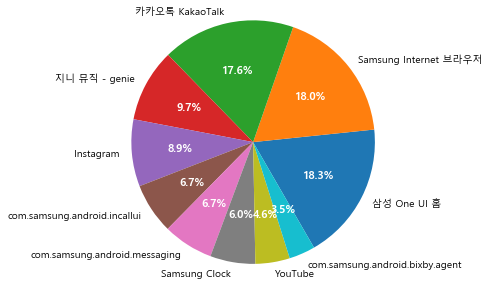

In [13]:
android_service.visualizeTopCountApp(10)